In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, pipeline
from sklearn.preprocessing import PolynomialFeatures

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

import class_helper
%aimport class_helper


import recipe_helper
%aimport recipe_helper


# Transformation to add a "missing" numeric feature


## Regression: missing feature

We have seem an example of a missing numeric feature in the past.

Recall our example illustrating linear regression
- the first model hypothesized the relationship as

$$ \y = \Theta_0 + \Theta_1  \x $$

- Error Analysis revealed a systemic error
- Causing us to add another feature (the square of the first feature)

$$ \y = \Theta_0 + \Theta_1  \x + \Theta_2  \x^2$$

Coefficients: 
 [64.04203363] [[0.1996918]]


R-squared (test): 0.99
Root Mean squared error (test): 12.48


R-squared (train): 0.99
Root Mean squared error (train): 11.78


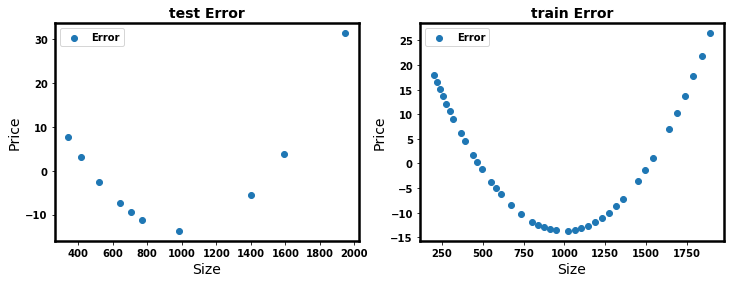

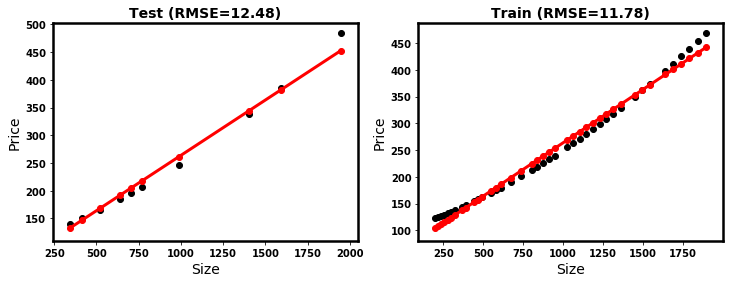

In [4]:
v1, a1 = 1, .005
lin = recipe_helper.Recipe_Helper(v = v1, a = a1)

X_lin, y_lin = lin.gen_data(num=50)

(xlabel, ylabel) = ("Size", "Price")
fig, axs = lin.regress_with_error(X_lin, y_lin, xlabel=xlabel, ylabel=ylabel, visible=False)
fig


## Classification: missing feature

The Logistic Regression Classifier
- is a type of Classifier
- that creates a *linear surface* to separate classes

<table>
    <tr>
        <center><strong>Separation bounday as function of probability threshold</strong></center>
    </tr>
<img src="images/class_overview_prob_lines.jpg" width=90%>
</table>



But what if the data is such that a linear surface cannot separate classes ?
- we can use a classifier that *does not* assume linear separability (KNN, Decision Trees)
- **or** we can add a feature to make the classes linearly separable
    - here: we illustrate with a numeric feature

Consider Binary Classification on the following "bulls-eye" dataset.

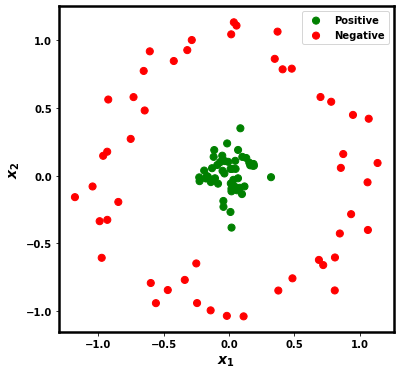

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
Xc, yc = svmh.make_circles(ax=ax, plot=True)

Visually, we can see that the classes are separable, but clearly not by a line.

Here's what one linear classifier (an SVC, which we will study later) produces

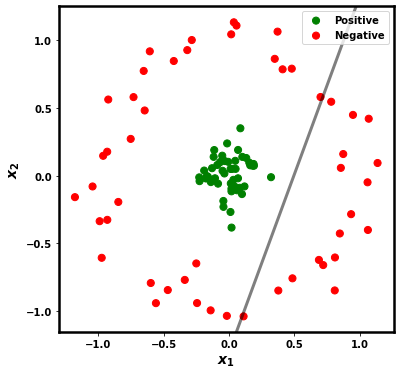

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
svm_clf = svmh.circles_linear(Xc, yc, ax=ax)

Let's add a new *numeric* feature defined by the (Gaussian) *Radial Basis Function (RBF)*
$$
\x_3 = e^{ - \sum_j { \x_j^2 } }
$$

Our features are now 3 dimensional; let's look at the plot:

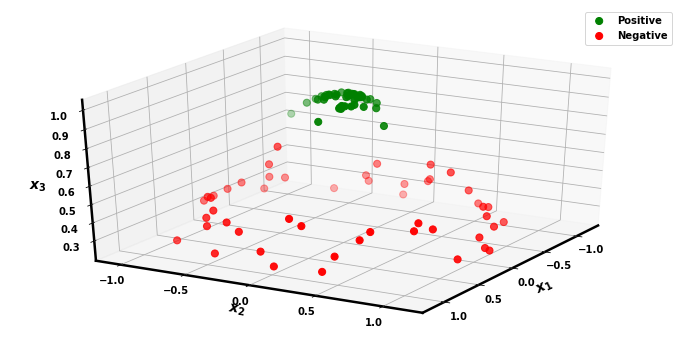

In [7]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! 

The new feature is such that it is
- greatest at origin $(\x_1, \x_2) = (0, 0)$
- decreasing as you move away from the origin

The new feature enables a plane that is parallel to the $\x_1, \x_2$ plane to separate the two classes.

We can write the RBF transformation to reference an arbitrary origin $\x_c$
$$
\text{RBF}(\x) = e^{ - || \x - \x_c || }
$$

- $|| \x - \x_c ||$ is a measure of the distance between example $\x$ and reference point $\x_c$
- In our case
    - $|| \x - \x_c ||$ is the L2 (Euclidean) distance
    - $\x_c$ is the origin $(0, 0)$

There is an even simpler transformation we could have used 

$$ 
\x_3 = - || \x - \x_c ||^2
$$

That is: the (negative) of the L2 distance.

The advantage of the RBF is that it has little effect on points far from the reference point.

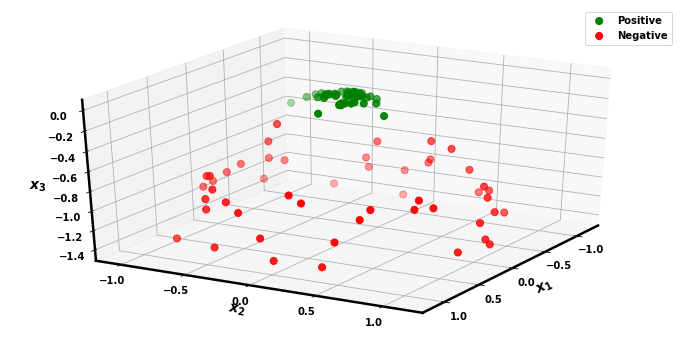

In [8]:
X_w_rad = svmh.circles_radius_transform(Xc)
_= svmh.plot_3D(X=X_w_rad, y=yc )

The common aspect of each transformation
- observation that there are a set of examples with green labels
- centered around a point (origin)

The transformation added a feature that was greatest in magnitude around those points.mm

### Curved boundaries and Linear Classifiers

Recall the transformation of adding a higher order polynomial feature for the "curvy" dataset

$$ \y = \Theta_0 + \Theta_1  \x + \Theta_2  \x^2$$

This equation is *still linear* in the two features $\x_1$ and $\x^2_1$.

In Classification, we can created *curved boundaries* that are *still linear* in their features.
- But clearly not linear in raw features

The two plots below use a Classifier requiring Linear Separability of the examples
- the right plot adds a polynomial feature
- creating a curved boundary
- even though the equation is still linear in the features

In [9]:
svmh = svm_helper.SVM_Helper()

_= svmh.create_kernel_data()

gamma=1
C=0.1

linear_kernel_svm = svm.SVC(kernel="linear", gamma=gamma)

# Pipelines
feature_map_poly2 = PolynomialFeatures(2)
poly2_approx = pipeline.Pipeline( [ ("feature map", feature_map_poly2),
                                    ("svm", svm.LinearSVC())                 
                                  ])

classifiers =  [ ("SVC", linear_kernel_svm),
                ("poly (d=2) transform + SVC", poly2_approx)
               ]
_= svmh.create_kernel_data(classifiers=classifiers)      
fig, axs = svmh.plot_kernel_vs_transform()
plt.close()

/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


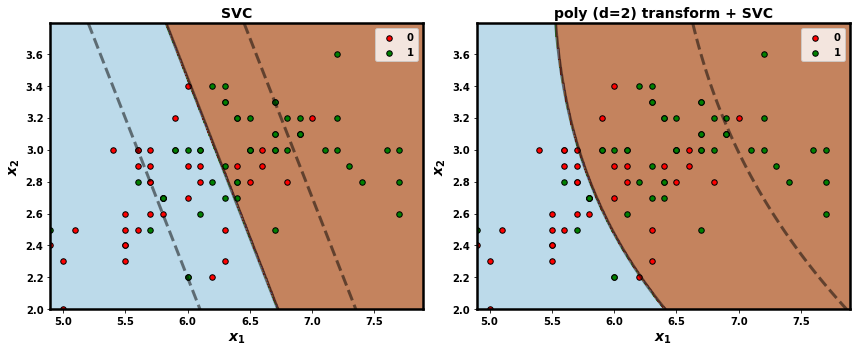

In [10]:
fig

- Left plot shows a boundary that is linear in raw features
- Right plot show a boundary that is linear in transformed features
    - plotted in the dimensions of raw features

The transformation results in a boundary shape with greater flexibility.

# Transformations should be motivated by logic, not magic !

Although the transformation on the "bulls-eye" dataset seems magical, we must be skeptical of magic
- There should be some *logical* justification for the added feature
- Without such logic: we are in danger of overfitting and will fail to generalize to test examples

For example:
- Perhaps $\x_1, \x_2$ are geographic coordinates (latitude/longitude)
- There is a distinction (different classes) based on distance from the city center $(\x_1, \x_2) = (0,0)$
    - e.g. Urban/Suburban


# Transformation to add a "missing" categorical feature

Recall the dataset where training examples formed two distinct groups
- samples at different points in time

In [11]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig, ax = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax)

plt.close(fig)

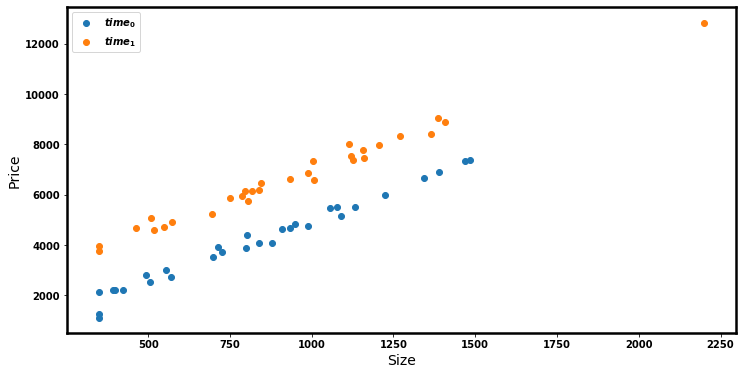

In [12]:
fig

How do we pool data that is similar intra-group but different across groups ?

In the above example, it appears that
- The groups are defined by examples gathered at different times: $\text{time}_0, \text{time}_1$
- There is a linear relationship *in each group* in isolation
- There slope of the relationship is *the same* across time
- But the intercept differs across groups
    - Perhaps this reflects a tax or rebate that is independent of price.
    



If we are correct in hypothesizing that each group is from the same distribution *except for* different intercepts
- the following set of equations describes the data (separately for each of the two groups):
$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$

Trying to fit a line (Linear Regression) as a function of the combined data will be disappointing.
- it will try to force a common intercept
$$
\y = \Theta_0 + \Theta_1 * \x
$$

when we know that the intercepts are different

We can derive a *single equation* describing both groups by adding
- a Categorical feature `Group`
- with two possible class values
- indicating which group the example belongs to

Using OHE to encode this categorical feature. we create two binary indicators $\text{Is}_0, \text{Is}_1$

$$
\text{Is}_j^\ip = 
\left\{
    {
    \begin{array}{lll}
     1 & \textrm{if } \x^\ip  \text{ is in group } j  &  \\
     0 & \textrm{if } \x^\ip  \text{ is NOT in group } j  &  \\
    \end{array}
    }
\right.
$$

To illustrate: for example $i$ in time 0 group, we have

$$
\begin{array}[lll]\\
\text{Is}_0^\ip = 1 \\
\text{Is}_1^\ip = 0 \\
\end{array}
$$

This results in the following equation

$$
\begin{array}[lll]\\
\y & = & \Theta_{(\text{time}_0)} * \text{Is}_0 + \Theta_{(\text{time}_1)} * \text{Is}_1  + \Theta_1 * \x \\
\end{array}
$$

Effectively, the equation allows each group to have its own intercept !
- because $\text{Is}_0$ and $\text{Is}_1$ are complementary

This transformation caused examples
-  that appear different *at the surface level* 
- to become *similar* by revealing the *deeper* relationship

Here's what the design matrix $\X''$ looks like when we add the two indicators:

$
  \X'' = \begin{pmatrix}
  \mathbf{Is}_0 & \mathbf{Is}_1  & \mathbf{other \; features}\\
  1 & 0  & \ldots \\ 
   0 & 1  & \ldots\\ 
   \vdots \\
  \end{pmatrix}
  \begin{matrix}\\
  \text{time}_0 \\
  \text{time}_1 \\
  \\
  \end{matrix}
$

- Examples from the first time period look similar to the first row
- Examples from the second time period look similar to the second row

Because $ \mathbf{Is}_0 $ and $ \mathbf{Is}_1$ are complementary
- we have an instance of the *Dummy Variable Trap*
- we need the usual solution of dropping one binary indicator
    - resulting in 
    $$
\begin{array}[lll]\\
\y & = & \Theta_0 + \Theta'_{(\text{time}_1)} * \text{Is}_1   + \Theta_1 * \x \\
\end{array}
$$
    - the intercept term $\Theta_0$ captures the contribution to $\y$ of examples in group $0$
    - the coefficient $\Theta'_{(\text{time}_1)}$ captures the *incremental* contribution to $\y$ of being in group 1 rather than group 0

# Bucketing: making a numeric feature into a Categorical feature

The effect of some features may not have a linear effect on the probability
predicted by a Classifier.

Recall the `Age` feature from the Titanic Survival Classification problem.

Our analysis suggested that the Survival probability
- is **not** linear in `Age`

Trying to force `Age` into a linear model would not be appropriate.

Instead, we can create a Categorical synthetic feature `AgeBucket`
- with class values indicating whether age is in buckets of width 15 years
    $$[0,15), [15, 30), [30, 45), [45, 60), [60, 75)$$
    
Using OHE: we have a binary indicator for each bucket.

This is an example of 
- replacing a numeric raw feature
- with a Categorical synthetic feature

to better match the characteristics of the model

# Cross features

In our EDA for the Titanic Classification problem we discovered
- being a Female *seemed* to increase the chances of being in the `Survived` class
- but [deeper analysis](Classification_and_Non_Numerical_Data.ipynb#Conditional-survival-probability-(condition-on-multiple-attributes)) should this to be true *conditional* on not being in Third Class

It seems that we need to identify a group defined by the *intersection* of two conditions
- $\text{Is}_\text{Female}$ and $\text{Is}_{\text{PClass} \ne 3}$

That is, we want to create a feature $\text{FNTC}$ (Female Not Third Class)
- that is True
- only for examples whose features are `Sex = Female` and `PClass` $ \ne 3$

We first create two separate binary features
$$
\text{Is}_\text{Female}
$$
and
$$
\text{Is}_{\text{PClass} \ne 3}
$$

We can create a binary indicator that is the **intersection** of two binary indicators by multiplication
 $$
 \text{Is}_\text{FNTC} = \text{Is}_\text{Female} *\text{Is}_{\text{PClass} \ne 3}
 $$
 
 This is called a *cross feature* or a *cross term*.
 
 

This cross-feature serves the same purpose as the numeric feature we added to the bulls-eye dataset
- a feature that isolates a subset of examples

In fact, we can use a cross-feature for the bulls-eye dataset
- two binary features
    - one indicating $\x_1^\ip$ is close to $0$
    - one indicating $\x_2^\ip$ is close to $0$
- a cross-feature that indicates that $\x^\ip$ is close to $(0,0)$
    - as the product of the two binary features


Here we create a cross feature that is `True` if two simpler features hold simultaneously
- $\text{Is}_{\text{near zero } \x_1}$ near zero indicator: $ = - \epsilon \le \x_1 \le \epsilon$
- $\text{Is}_{\text{near zero } \x_2}$ near zero indicator: $ = - \epsilon \le \x_2 \le \epsilon$

The cross feature that identifies examples near $(0,0)$ is
- $\text{Is}_{\text{near} (0,0)} = \text{Is}_{\text{near zero } \x_1} * \text{Is}_{\text{near zero } \x_2}$

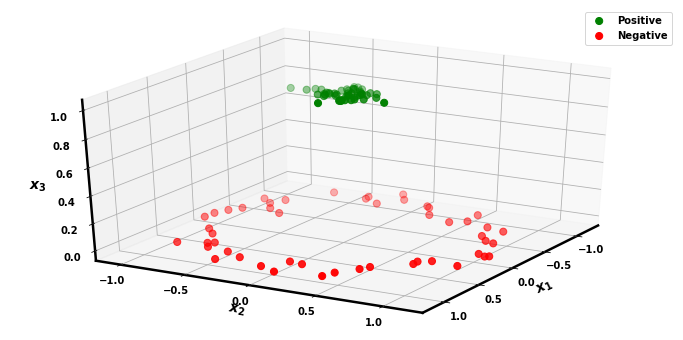

In [13]:
X_w_sq = svmh.circles_square_transform(Xc)
_= svmh.plot_3D(X=X_w_sq, y=yc )

## Cross-features can be abused

Cross terms are very tempting but can be abused when over-used.
- they can be used to identify small subsets of examples for special treatment
- taken to the extreme
    - they can create *one indicator for each training example*
    - essentially: memorizing the training dataset

Memorization of the training set
- usually results in failure to generalize out of sample
- is a hallmark of over-fitting


Here's a picture of the "per example" indicator

First, construct an indicator which is true
- if an example's feature $j$ value is equal to the feature $j$ value of example $i$:

$$
\text{Is}_{\x^\ip_j} = (\x_j = \x^\ip_j)
$$

Now construct a cross feature that combines the indicators for all $j$ and a single example $i$:
$$
\begin{array}[lll]\\
\text{Is}_{\text{example }i} & = & (\x_1 = \x_1^\ip) * (\x_2 = \x_2^\ip)\\
\end{array}
$$

This cross feature will be true on example $i$.

We can construct such a cross feature that recognizes any single example.

And here's the design matrix $\X''$ with a separate intercept per example.

$\X''$ has $m$ intercept columns, one for each example,
forming a diagonal of 1's

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & \text{Is}_{\text{example 2}} & \text{Is}_{\text{example 3}} & \ldots & \mathbf{other \; features}\\
  1 &  1 & 0  & 0 & \ldots \\ 
  1 &  0 & 1  & 0 & \ldots\\ 
  1 &  0 & 0  & 1 &\ldots\\ 
   \vdots \\
  \end{pmatrix}
$

We can do the same for $\Theta_1, \Theta_2, \ldots, \Theta_n$
resulting in a design matrix $\X''$ with $m * n$ indicators
- One per example per parameter


Here's a design matrix $\X''$ with one set of parameters per example:
\
$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & (\text{Is}_{\text{example 1}} *\x_1) & (\text{Is}_{\text{example 1}} * \x_2) & \ldots & \text{Is}_{\text{example 2}} & (\text{Is}_{\text{example 2}} *\x_1) & (\text{Is}_{\text{example 2}} * \x_2) & \ldots\\
  1 &  1 & \x^{(1)}_1  & \x^{(1)}_2 & \ldots & 0 & 0 & 0\\ 
  1 &  0 & 0          & 0         & \ldots  &  1 & \x^{(2)}_1  & \x^{(2)}_2 \\  
   \vdots \\
  \end{pmatrix}
$

Using this as the design matrix in Linear Regression
- Will get a perfect fit to training examples
- Would likely **not generalize** well to out of sample test examples.

When truly justified a small number of complex cross terms are quite powerful.

In [14]:
print("Done")

Done
